## 裁剪图片

各种参数解释(https://sites.google.com/site/ritpanoramaapp/project-stage-iii)

重新运行一次

[INFO] loading images...
[INFO] stitching images...
[INFO] cropping...
[INFO] image size=(1031, 1967)


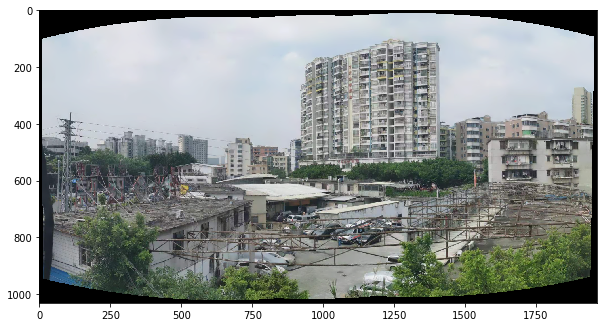

In [11]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2

import sys
sys.path.append('..')
from opencv_course import ImageUtil


print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images('image2')))
images = []
 
# loop over the image paths, load each one, and add them to our
# images to stich list
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    images.append(image)
 
# initialize OpenCV's image sticher object and then perform the image
# stitching
print("[INFO] stitching images...")
stitcher = cv2.Stitcher_create(0)
(status, stitched) = stitcher.stitch(images)

# check to see if we supposed to crop out the largest rectangular
# region from the stitched image
# create a 10 pixel border surrounding the stitched image
print("[INFO] cropping...")
stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10, cv2.BORDER_CONSTANT, (0, 0, 0))

print("[INFO] image size={}".format(stitched.shape[:2]))
ImageUtil.imshow([stitched])

<Figure size 1080x720 with 0 Axes>

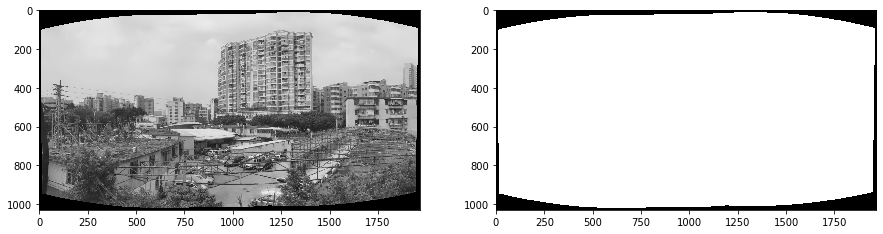

In [12]:
# convert the stitched image to grayscale and threshold it
# such that all pixels greater than zero are set to 255
# (foreground) while all others remain 0 (background)
gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

ImageUtil.imshow([gray, thresh], columns=2, rows=1, figsize=(15,10))

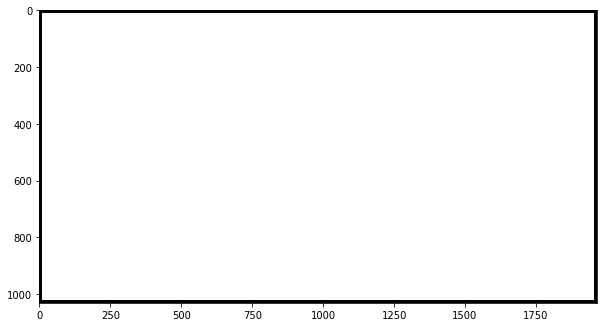

In [13]:
# find all external contours in the threshold image then find
# the *largest* contour which will be the contour/outline of
# the stitched image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# allocate memory for the mask which will contain the
# rectangular bounding box of the stitched image region
mask = np.zeros(thresh.shape, dtype="uint8")
(x, y, w, h) = cv2.boundingRect(c)
cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

ImageUtil.imshow([mask])

[cv2.erode](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#gaeb1e0c1033e3f6b891a25d0511362aeb)

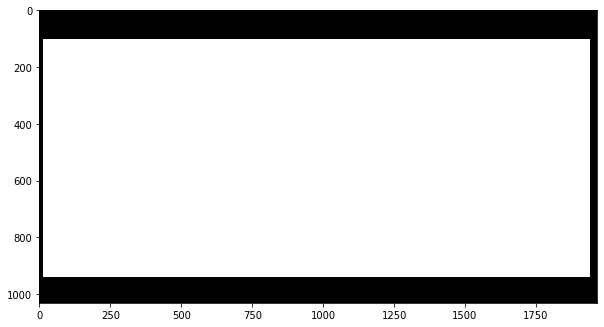

In [14]:
# create two copies of the mask: one to serve as our actual
# minimum rectangular region and another to serve as a counter
# for how many pixels need to be removed to form the minimum
# rectangular region
minRect = mask.copy()
sub = mask.copy()

# keep looping until there are no non-zero pixels left in the
# subtracted image
zero_cnt = cv2.countNonZero(sub)
(h, w) = minRect.shape
top_width = 1
bottom_width =1
left_width = 1
right_width = 1

while zero_cnt > 0:
    # erode the minimum rectangular mask and then subtract
    # the thresholded image from the minimum rectangular mask
    # so we can count if there are any non-zero pixels left
    test_top = minRect.copy()
    cv2.line(test_top,(0,0),(w,0),(0,0,0),top_width)
    top_zero = cv2.countNonZero(cv2.subtract(test_top, thresh))
    
    test_bottom = minRect.copy()
    cv2.line(test_bottom,(0,h),(w,h),(0,0,0),bottom_width)
    bottom_zero = cv2.countNonZero(cv2.subtract(test_bottom, thresh))
    
    test_left = minRect.copy()
    cv2.line(test_left,(0,0),(0,h),(0,0,0),left_width)
    left_zero = cv2.countNonZero(cv2.subtract(test_left, thresh))
    
    test_right = minRect.copy()
    cv2.line(test_right,(w,0),(w,h),(0,0,0),right_width)
    right_zero = cv2.countNonZero(cv2.subtract(test_right, thresh))
    
    zero_cnt = min(top_zero, bottom_zero, left_zero, right_zero)

    if top_zero == zero_cnt:
        top_width+=8
        minRect = test_top

    if bottom_zero == zero_cnt:
        bottom_width +=8
        minRect = test_bottom

    if left_zero == zero_cnt:
        left_width+=8
        minRect = test_left

    if right_zero == zero_cnt:
        right_width+=8
        minRect = test_right

    sub = cv2.subtract(minRect, thresh)
    
ImageUtil.imshow([minRect])

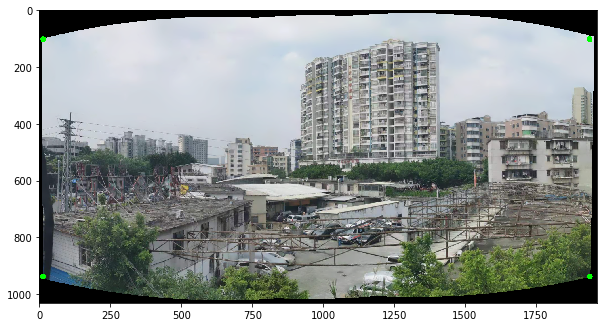

In [16]:
# find contours in the minimum rectangular mask and then
# extract the bounding box (x, y)-coordinates
cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cpyImg = stitched.copy()
for c in cnts:
    cv2.drawContours(cpyImg, c, -1, (0, 255, 0), 20)

ImageUtil.imshow([cpyImg])

w:1928, h:836


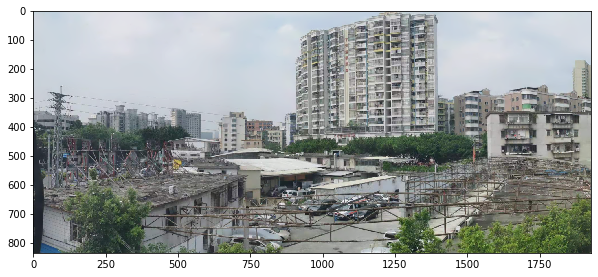

In [17]:
c = max(cnts, key=cv2.contourArea)
(x, y, w, h) = cv2.boundingRect(c)

print("w:{}, h:{}".format(w, h))
# use the bounding box coordinates to extract the our final
# stitched image
stitched = stitched[y:y + h, x:x + w]

ImageUtil.imshow([stitched.copy()])

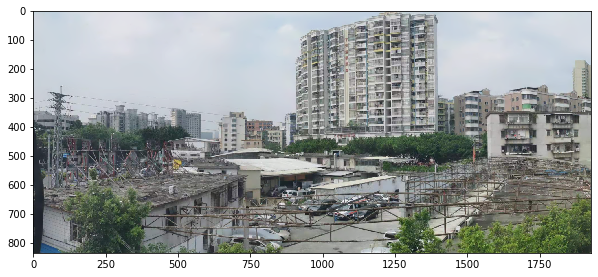

In [18]:
# write the output stitched image to disk
cv2.imwrite('result2.jpg', stitched)

# display the output stitched image to our screen
ImageUtil.imshow([stitched])